In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import warnings
warnings.filterwarnings("ignore")
sys.path.append('../../')
import src.models.UNSW_NB15_models.DetectionModel as models

from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report



In [2]:
# Set the style of the plot to a dark background
sns.set_style("whitegrid")

# Customize the seaborn style with specific colors and context settings
sns.set(rc={
    "axes.facecolor": "#f2e5ff",  # Set the face color of the axes to a light violet
    "figure.facecolor": "#f2e5ff",  # Set the face color of the entire figure to a light violet
    "grid.color": "#e0c3ff"  # Set the color of the grid lines to a soft violet
})

# Set the context to "poster" size with a specific font scale
sns.set_context("poster", font_scale=0.7)

# Define custom color palettes for seaborn plots
palette = ["#8a2be2", "#9370db", "#ba55d3", "#dda0dd", "#ee82ee"]
palette_cmap = ["#9370db", "#ba55d3", "#8a2be2", "#dda0dd", "#ee82ee"]

In [3]:
# Test data path
test_path = '../../data/UNSW_NB15_data/test_set_without_labels.parquet'

# Load test data
test_data = pd.read_parquet(test_path)

# Load test labels 
test_labels = pd.read_parquet('../../data/UNSW_NB15_data/test_set_labels.parquet')['label']

# Load the model
test_model = models.DetectionModel()

# Predict the results
test_results = test_model.predict(test_data)
test_results_prob = test_model.predict_proba(test_data)

In [4]:
# Print the classification report
print(classification_report(test_labels, test_results))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89     37000
           1       0.89      0.94      0.92     45332

    accuracy                           0.91     82332
   macro avg       0.91      0.90      0.90     82332
weighted avg       0.91      0.91      0.91     82332



In [5]:
def ROC_AUC_Visualization(y_test, predictions_prob):
    """
    Plots the ROC curve and calculates the AUC score for the given true labels and predicted probabilities.

    Parameters:
    - y_test : array-like
        The true labels for the dataset.
    - predictions_prob : array-like
        The predicted probabilities for the positive class.

    Returns:
    - float
        The calculated AUC score.
    """
    
    # Calculate the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, predictions_prob)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='#ee82ee', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12, color='#4b0082')
    plt.ylabel('True Positive Rate', fontsize=12, color='#4b0082')
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=16, color='#4b0082', weight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()


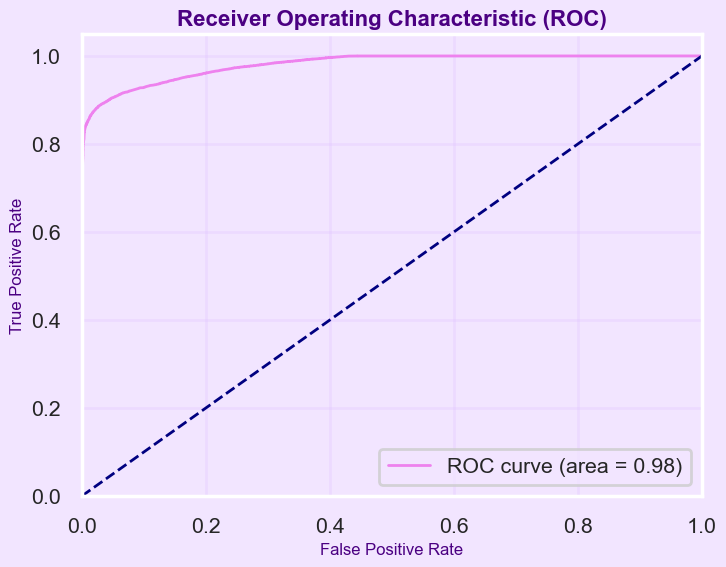

In [6]:
ROC_AUC_Visualization(test_labels, test_results_prob[:, 1])

In [7]:
def plot_confusion_matrix(cm):
    # Define custom colormap
    colors = ["white", "#ba55d3"]
    cmap = LinearSegmentedColormap.from_list("Custom", colors)

    # Plotting the confusion matrix with borders
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False, linewidths=1, linecolor='#4b0082')

    # Customize labels and title
    plt.xlabel('Predicted Labels', fontsize=14, color='#4b0082')
    plt.ylabel('True Labels', fontsize=14, color='#4b0082')
    plt.title('Confusion Matrix', fontsize=16, weight='bold', color='#4b0082')

    # Show plot
    plt.show()

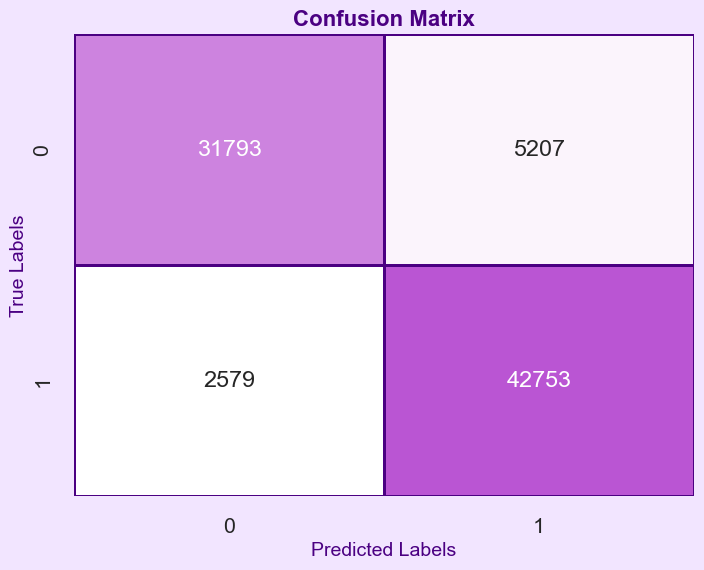

In [8]:
# Calculate the confusion matrix
cm = confusion_matrix(test_labels, test_results)

plot_confusion_matrix(cm)

In [9]:
def calculate_metrics(y_true, y_pred_prob, threshold):
    y_pred = (y_pred_prob >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    return precision, recall, f1

thresholds = np.arange(0.1, 1, 0.05)  # Example thresholds

results = []
for threshold in thresholds:
    precision, recall, f1 = calculate_metrics(test_labels, test_results_prob[:, 1], threshold)
    results.append([threshold, precision, recall, f1])


results_df = pd.DataFrame(results, columns=['Threshold', 'Precision', 'Recall', 'F1 Score'])
results_df

,Threshold,Precision,Recall,F1 Score
0,0.10,0.741891,0.999029,0.851470
1,0.15,0.751418,0.996691,0.856848
2,0.20,0.766014,0.992698,0.864747
3,0.25,0.780790,0.988044,0.872275
4,0.30,0.803452,0.980742,0.883288
5,0.35,0.827693,0.973286,0.894605
6,0.40,0.849474,0.963800,0.903033
7,0.45,0.872858,0.952727,0.911045
8,0.50,0.891430,0.943109,0.916542
9,0.55,0.916124,0.930755,0.923382


In [10]:
def plot_feature_importance(model, feature_names,  num_features=10, show='head'):
    """
    Plots feature importance for a trained XGBoost model with enhanced styling.
    
    Parameters:
    - model: Trained model.
    - X_train: DataFrame with the training data (used to extract feature names).
    - num_features: Number of top/bottom features to display.
    - show: 'head' to display top features, 'tail' to display bottom features.
    """
    # Get feature importance scores from the model
    feature_importances = model.get_feature_importance()

    # Create a DataFrame for easier sorting and plotting
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Select top or bottom features based on the `show` parameter
    if show == 'head':
        plot_df = importance_df.head(num_features)
    elif show == 'tail':
        plot_df = importance_df.tail(num_features)
    else:
        raise ValueError("Invalid value for 'show'. Use 'head' or 'tail'.")

    # Create the plot with enhanced styling
    plt.figure(figsize=(12, 6))
    
    # Create horizontal bars with specific styling
    bars = plt.barh(plot_df['Feature'], 
                   plot_df['Importance'],
                   color=palette[3],
                   edgecolor='#4b0082',
                   linewidth=2,
                   height=0.7)

    # Customize the plot appearance
    plt.xlabel('Importance', color='#4b0082', fontsize=16)
    plt.ylabel('Feature', color='#4b0082', fontsize=16)
    plt.title(f'Feature Importance ({show} {num_features} features)',
             color='#4b0082',
             fontsize=20,
             fontweight='bold')

    # Customize tick labels
    plt.xticks(color='#4b0082', fontsize=12)
    plt.yticks(color='#4b0082', fontsize=12)

    # Add grid with specific styling
    plt.grid(axis='x', linestyle='--', alpha=0.3)

    # Invert y-axis for better readability
    plt.gca().invert_yaxis()

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

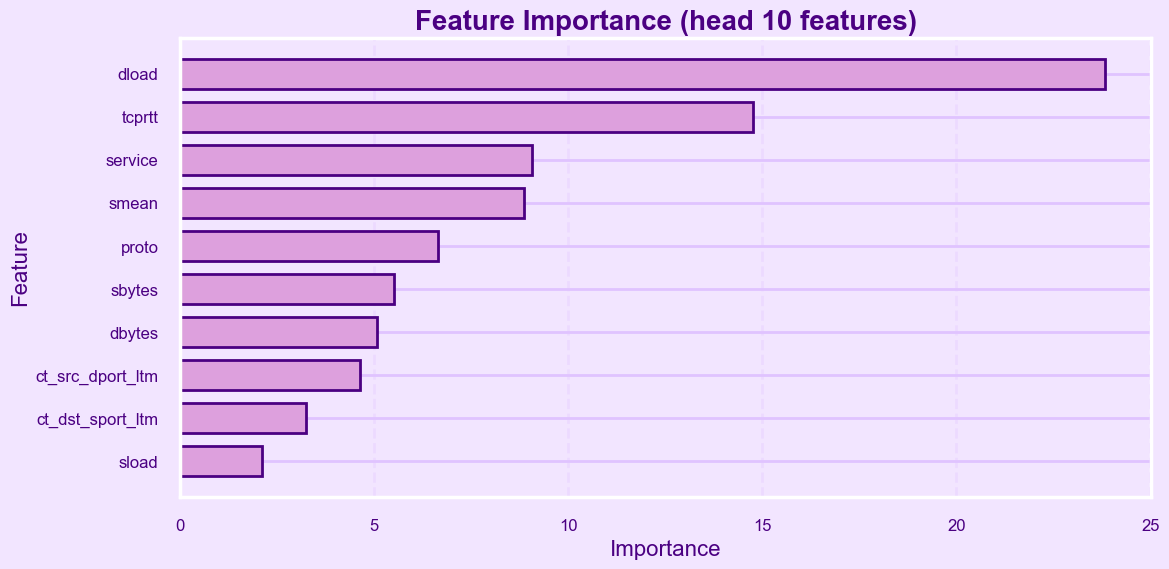

In [11]:
feature_names = test_model.model.feature_names_
plot_feature_importance(test_model.model, feature_names,  num_features=10, show='head')  # To display top 10 features

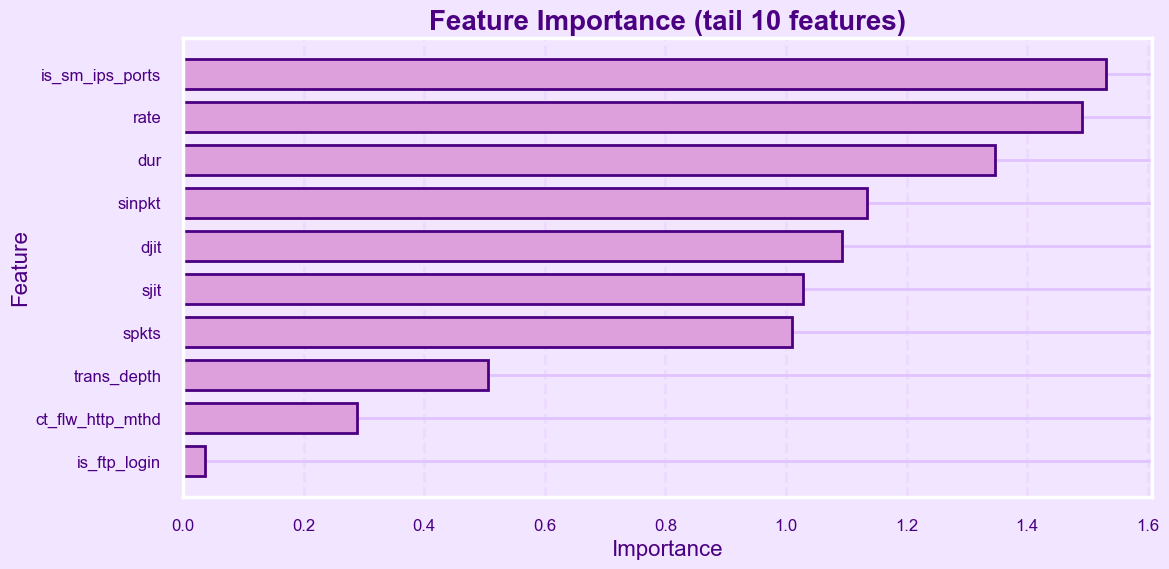

In [12]:
plot_feature_importance(test_model.model, feature_names,  num_features=10, show='tail')  # To display bottom 10 features